In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time 
from tqdm import tqdm

In [200]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

In [201]:
def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

In [202]:
def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model


In [203]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [204]:
def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0

In [205]:
def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)

In [206]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ##Pre Training the neural network
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1), epochs=1000, batch_size=int(0.1 * sample_size), verbose=0)
    ## Pre Training completed   
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)
    
    # Test the model
    y_hat_val = model.predict(X_test)
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    #plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    #sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    #X_train_sorted = X_train[sorted_indices]
    #y_hat_sorted = y_hat_val[sorted_indices]
    #plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    #plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        y_hat = model.predict(X_test)
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0, 0], weights, errors

    

In [207]:
S0 = 50                                 # Initial stock price
K = 50                                  # Strike price
mu = 0.06                               # Risk free rate
sigma = 0.2                             # Volatility
T = 1                                   # Time to maturity
N = 6                                   # Number of monitoring dates
hidden_units = 4                        # Number of hidden units in the neural network
ler_rate = 0.01                         # Learning rate
M = 5000                                # Number of sample paths


In [105]:
option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', 4, ler_rate)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


In [ ]:
hidden_units = list([4, 8, 16, 32, 64, 128])
option_prices = []
times = []
errors = []

for no_hidden_units in tqdm(hidden_units):
    start_time = time.time()
    option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', no_hidden_units, ler_rate)
    end_time = time.time()
    times.append(end_time - start_time)
    option_prices.append(option_price)
    errors.append(error) 

### Optimal Hidden Units

In [111]:
hidden_units = [4, 8, 16, 32, 64, 128]
option_prices = []
times = []
errors = []
confidence_intervals = []

# Number of simulations per hidden unit configuration
n_simulations = 10  # Adjust based on computational resources

for no_hidden_units in tqdm(hidden_units):
    option_prices_temp = []
    times_temp = []
    errors_temp = []

    for _ in tqdm(range(n_simulations)):
        start_time = time.time()
        option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', no_hidden_units, ler_rate)
        end_time = time.time()

        times_temp.append(end_time - start_time)
        option_prices_temp.append(option_price)
        errors_temp.append(error)
    
    # Calculate mean and confidence interval
    mean_price = np.mean(option_prices_temp)
    std_dev_price = np.std(option_prices_temp)
    ci = 1.96 * std_dev_price / np.sqrt(n_simulations)  # 95% confidence level

    # Store results
    times.append(np.mean(times_temp))
    option_prices.append(mean_price)
    errors.append(np.mean(errors_temp))
    confidence_intervals.append(ci)



  0%|          | 0/6 [00:00<?, ?it/s]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


 17%|█▋        | 1/6 [04:13<21:06, 253.32s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


 33%|███▎      | 2/6 [09:08<18:31, 277.91s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step


 50%|█████     | 3/6 [14:39<15:06, 302.23s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


 67%|██████▋   | 4/6 [22:38<12:23, 371.85s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


 83%|████████▎ | 5/6 [34:32<08:15, 495.20s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


100%|██████████| 6/6 [54:29<00:00, 544.87s/it]


In [112]:
option_prices = np.array(option_prices)
times = np.array(times)
errors = np.array(errors)

In [124]:
option_prices

array([3.43529832, 2.76821661, 2.76401695, 2.75579229, 2.75305928,
       2.75378089])

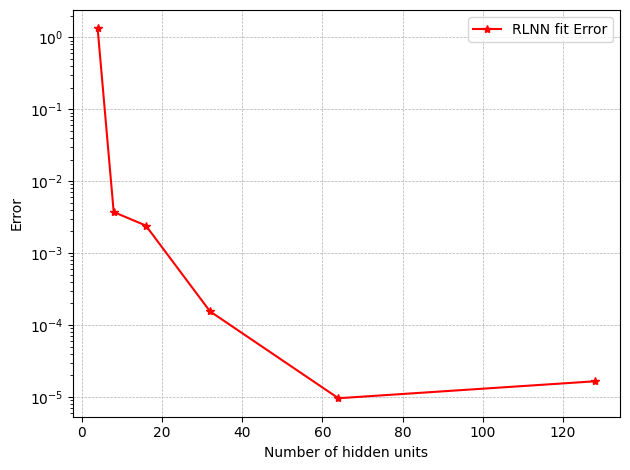

In [195]:

plt.plot(hidden_units[:], errors[:],label='RLNN fit Error', marker='*', color='r')
plt.yscale('log')
plt.xlabel('Number of hidden units')
plt.ylabel('Error')
# Add grid and legend
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.savefig('Error_vs_Hidden_units.png')

### Performance (time) Vs Hidden Units

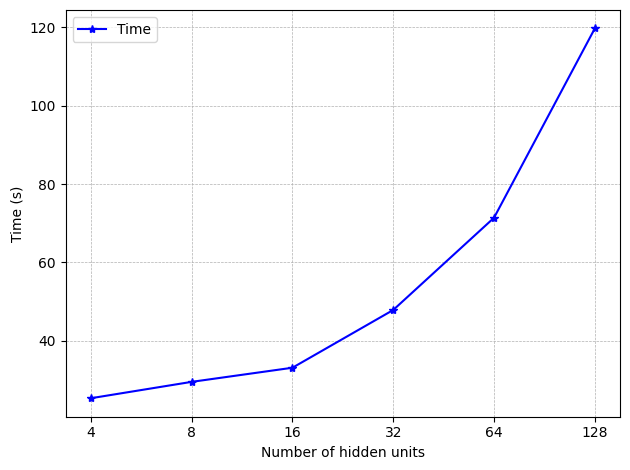

In [194]:

plt.plot(hidden_units, times, label='Time', marker='*', color='b')
plt.xscale('log', base=2)
# Customize ticks to show 2, 4, 8, etc.
ticks = hidden_units
plt.xticks(ticks, labels=[str(tick) for tick in ticks])

# Label the axes
plt.xlabel('Number of hidden units')
plt.ylabel('Time (s)')

# Add grid and legend
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Time_vs_Hidden_units.png')
plt.show()

In [148]:
n_steps = 6 * 8
exercise_dates = np.arange(1/6, 1.00001, 1/6)
binomial_price = bermudan_option_binomial(S0, K, T, mu, sigma,  n_steps, exercise_dates, 'put')

In [192]:
hidden_units = [4, 8, 16, 32, 64, 128]

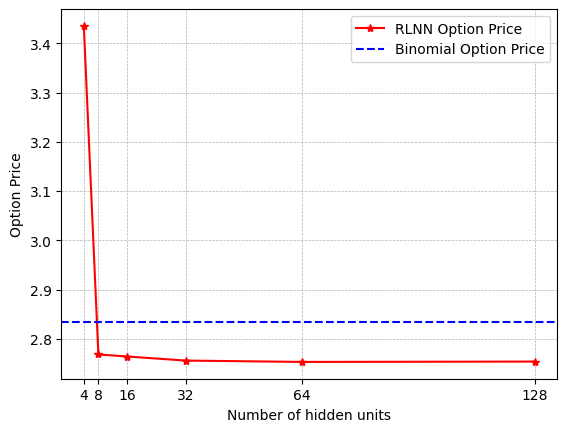

In [193]:
plt.plot(hidden_units, option_prices, label='RLNN Option Price', marker='*', color='r')
plt.axhline(y = binomial_price, label='Binomial Option Price', color='b', linestyle='--')  
ticks = hidden_units
plt.xticks(ticks, labels=[str(tick) for tick in ticks])
plt.xlabel('Number of hidden units')
plt.ylabel('Option Price')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.savefig('Option_Price_vs_Hidden_units.png')

### Changes in Sample Size

In [171]:
sample_sizes = np.arange(1000, 10001, 500)
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 6
hidden_units = 32
option_prices_sim = []
errors_sim = []
times_sim = []

for M in tqdm(sample_sizes):
    option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
    option_prices_sim.append(option_price)
    errors_sim.append(error)
    times_sim.append(time.time())



  0%|          | 0/6 [00:00<?, ?it/s]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


 17%|█▋        | 1/6 [00:44<03:41, 44.24s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step


 33%|███▎      | 2/6 [01:49<03:46, 56.71s/it]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step


 50%|█████     | 3/6 [03:35<03:57, 79.28s/it]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step


 67%|██████▋   | 4/6 [05:49<03:21, 100.60s/it]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step


 83%|████████▎ | 5/6 [08:09<01:54, 114.91s/it]

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step


100%|██████████| 6/6 [11:01<00:00, 110.21s/it]


In [172]:
errors_sim  = np.array(errors_sim)
option_prices_sim = np.array(option_prices_sim)
times_sim = np.array(times_sim)

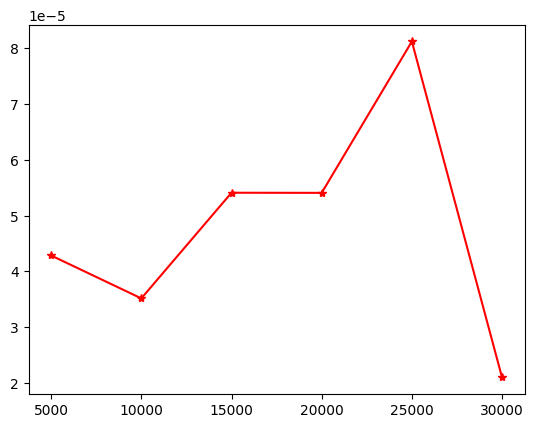

In [174]:
plt.plot(sample_sizes, errors_sim[:,-1], label='RLNN fit Error', marker='*', color='r')


In [177]:
sample_sizes = np.arange(1000, 10001, 500)
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 6
hidden_units = 32
option_prices_sim = []
errors_sim = []
times_sim = []
for M in tqdm(sample_sizes):
    ci_error = []
    time_n = []
    option_prices_n = []
    errors_n = []
    for _ in tqdm(range(5)):
        start_time = time.time()
        option_price, weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
        end_time = time.time()
        time_n.append(end_time - start_time)
        option_prices_n.append(option_price)
        errors_n.append(error)
    times_sim.append(np.array(time_n).mean())
    option_prices_sim.append(np.array(option_prices_n).mean())
    errors_sim.append(np.array(errors_n).mean())
    ci = 1.96 * np.std(option_prices_n) / np.sqrt(5)
    ci_error.append(ci)
    

  0%|          | 0/6 [00:00<?, ?it/s]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step


 17%|█▋        | 1/6 [03:46<18:50, 226.13s/it]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step


 33%|███▎      | 2/6 [09:26<19:32, 293.17s/it]

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


 50%|█████     | 3/6 [17:25<18:54, 378.01s/it]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step


 67%|██████▋   | 4/6 [27:29<15:34, 467.17s/it]

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step


 83%|████████▎ | 5/6 [39:22<09:15, 555.91s/it]

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step


100%|██████████| 6/6 [53:44<00:00, 537.34s/it]


In [178]:
option_prices_sim = np.array(option_prices_sim)
times_sim = np.array(times_sim)
errors_sim = np.array(errors_sim)

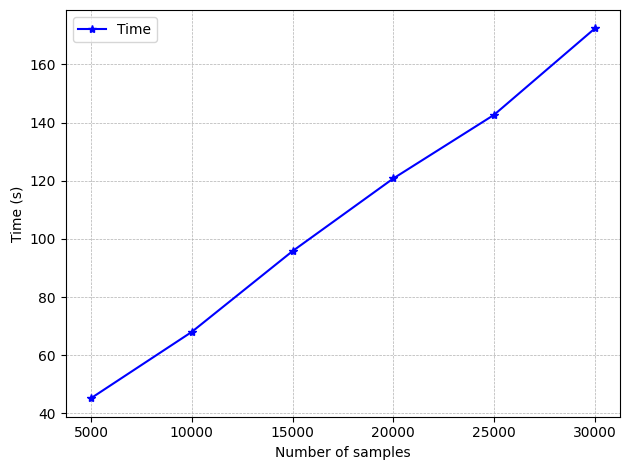

In [189]:
plt.plot(sample_sizes, times_sim, label='Time', marker='*', color='b')
plt.xlabel('Number of samples')    
plt.ylabel('Time (s)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('Time_vs_Samples.png')
plt.show()


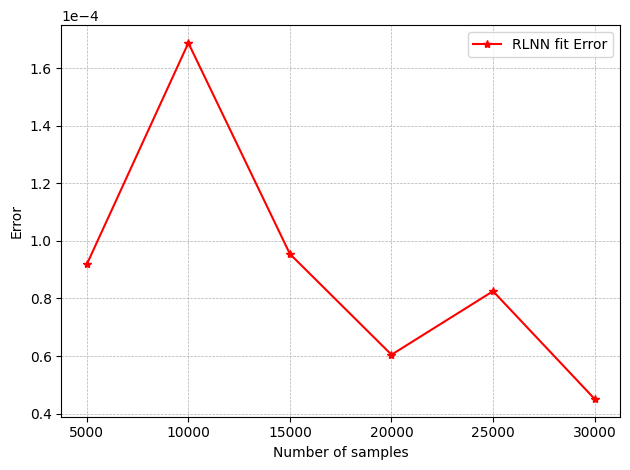

In [188]:
plt.plot(sample_sizes, errors_sim, label='RLNN fit Error', marker='*', color='r')
#plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Error')
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()
ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))  # Force scientific notation
# Adjust layout to fit everything
plt.tight_layout()
plt.savefig('Error_vs_Samples.png')
plt.show()

### Binomial Method

In [ ]:
def bermudan_option_binomial(S0, K, T, r, sigma, N, exercise_dates, option_type="call"):
    """
    Price a Bermudan option using the Binomial Tree method.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility of the underlying asset
    - N: Number of steps in the binomial tree
    - exercise_dates: List of times (as fractions of T) at which early exercise is allowed
    - option_type: "call" for call option, "put" for put option
    
    Returns:
    - The option price
    """
    
    # Calculate parameters for binomial tree
    dt = T / N  # Time increment
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    
    # Initialize asset prices at maturity
    stock_prices = np.zeros(N + 1)
    stock_prices[0] = S0 * d**N
    for i in range(1, N + 1):
        stock_prices[i] = stock_prices[i - 1] * u / d

    # Initialize option values at maturity
    option_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
    #print(option_values, stock_prices)
    
    # Backward induction for Bermudan option pricing
    for i in range(N - 1, -1, -1):
        stock_prices = stock_prices[:-1] * u  # Step back in time
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])
        
        # Apply early exercise at specified exercise dates
        if i * dt in exercise_dates:
            #print(f"Applying early exercise at time {i * dt}")
            exercise_values = np.maximum(0, (stock_prices - K) if option_type == "call" else (K - stock_prices))
            #print(exercise_values, stock_prices, K)
            option_values = np.maximum(option_values, exercise_values)

    return option_values[0]


In [ ]:
no_mon_dates = np.arange(2, 7, 1)
no_mon_dates

In [ ]:
no_mon_dates

### Lower Bounds

In [290]:
def calculate_lower_bound(stock_paths, K, r, sigma, T, no_mon_dates, option_type, trained_weights, nodes):
    """_summary_

    Args:
        S0 (_type_): _description_
        K (_type_): _description_
        r (_type_): _description_
        sigma (_type_): _description_
        T (_type_): _description_
        no_mon_dates (_type_): Number of monitoring dates
        option_type (_type_): _description_

    Returns:
        _type_: _description_
    """
    S0 = stock_paths[0, 0]
    dt = T / no_mon_dates
    M = stock_paths.shape[0]
    
    tau = np.full(stock_paths.shape[0], no_mon_dates-1)
    h_S = payoff_fun(stock_paths[:, no_mon_dates-1], K, option_type)
    
    for m in range(no_mon_dates-1):
        normalizer = S0
        St = stock_paths[:, m]    
        payoff_t = payoff_fun(St, K, option_type)
        current_weights = trained_weights[no_mon_dates - m - 2]
        weights_layer_1 = np.array(current_weights[0]).reshape(-1)
        biases_layer_1 = np.array(current_weights[1])
        weights_layer_2 = np.array(current_weights[2]).reshape(-1)
        biases_layer_2 = np.array(current_weights[3])
        continuation_value = cal_continuation_value(weights_layer_1, biases_layer_1, weights_layer_2, biases_layer_2, nodes, St, r, sigma, dt, M, normalizer)
        exceed = np.logical_and(payoff_t > continuation_value, tau > m)
        tau[exceed] = m
        h_S[exceed] = payoff_t[exceed]
        
        monitoring = np.arange(0, 1.01, 1/no_mon_dates)
        discounted_values = np.zeros(M, dtype=float)
        for j in range(M):
            discounted_values[j] = h_S[j] * np.exp(-r  * monitoring[tau[j]])

        lower_bound = np.mean(discounted_values)

    return lower_bound     

### Upper Bound

In [291]:
def upper_bound(rfr, vol, trained_weights, stock_paths, strike, monitoring, style, nodes):
    
    sample_size = len(stock_paths[:, 0])
    n_mon = len(monitoring)
    differences = np.diff(monitoring)

    b = np.exp(- rfr * np.cumsum(differences))
    b = np.insert(b, 0, 1)
    S0 = stock_paths[0, 0]

    rlnn = create_shallow_NN(1, nodes)

    martingale = np.zeros((sample_size, n_mon))

    for m in range(1, n_mon):
        normalizer = S0
        current_weights = trained_weights[- m]
        rlnn.set_weights(current_weights)
        w1 = np.array(current_weights[0]).reshape(-1)
        b1 = np.array(current_weights[1])
        w2 = np.array(current_weights[2]).reshape(-1)
        b2 = np.array(current_weights[3])
        q = cal_continuation_value(w1, b1, w2, b2, nodes, stock_paths[:, m - 1], rfr, vol, differences[m - 1], sample_size, normalizer)

        q_part = q * b[m - 1]
        g_part = (rlnn.predict(stock_paths[:, m] / normalizer, verbose=0) * b[m]).reshape(-1)

        martingale[:, m] = (g_part - q_part)

    martingale = np.cumsum(martingale, axis=1)

    payoffs = payoff_fun(stock_paths, strike, style)
    upr = np.mean(np.max(payoffs * b - martingale, axis=1))

    return upr

In [280]:
hidden_units = 32

In [281]:
price_, weight_, _ = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 203us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


In [287]:
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, 50000)
upper_bound(mu, sigma, weight_, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', hidden_units)

2.7554943723430316

In [292]:
stock_paths = stock_price_simulator(S0, mu, sigma, T, N, 10000)
calculate_lower_bound(stock_paths, K, mu, sigma, T, N, 'put', weight_, hidden_units)

2.6881443622875714

In [289]:
price_

2.751502669638768

In [412]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 4
M = 10000
n_steps = 4 * 50
exercise_dates = np.arange(0, 1.0001, 1/4)
b_prices = []
for n_steps in range(4, 4 * 50, 4):
    b_price = bermudan_option_binomial(S0, K, T, mu, sigma,  n_steps, exercise_dates, 'put')
    b_prices.append(b_price)



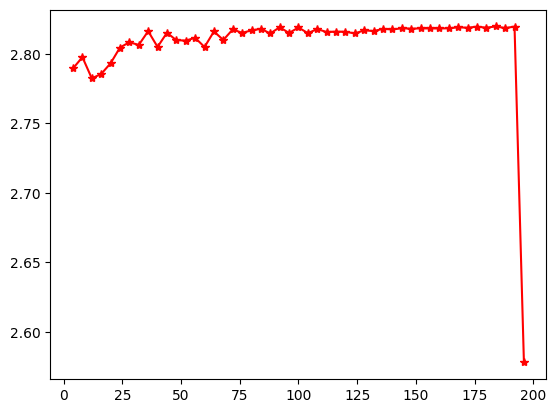

In [413]:
plt.plot(np.arange(4, 4 * 50, 4), b_prices, label='Binomial Option Price', marker='*', color='r')

In [348]:
black_scholes(S0, K, mu, sigma, T, 'put')

2.5830012555254314

In [410]:
M = 10000
N = 4
hidden_units = 4
T = 1
RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, 0.001)[0]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step


2.7720520454202577

In [437]:
no_hidden_units = [2, 4, 6, 8, 10, 16, 32]
option_prices_nodes = []
lower_Nodes = []
upper_Nodes = []
times_upper = []
times_lower = []
times_option = []
N_L = 20000
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
N = 4
M = 1500

for hidden_units in tqdm(no_hidden_units):
    start_time1 = time.time()
    option_price, trained_weights, error = RLNN_Algo(S0, K, mu, sigma, M, N, T, 'put', hidden_units, ler_rate)
    ends_time1 = time.time()
    option_prices_nodes.append(option_price)
    times_option.append(ends_time1 - start_time1)
    
    stock_paths = stock_price_simulator(S0, mu, sigma, T, N, N_L)
    start_time2 = time.time()
    lower_bound = calculate_lower_bound(stock_paths, K, mu, sigma, T, N, 'put', trained_weights, hidden_units)
    end_time2 = time.time()
    lower_Nodes.append(lower_bound)
    times_lower.append(end_time2 - start_time2)
    
    start_time3 = time.time()
    upper_bound1 = upper_bound(mu, sigma, trained_weights, stock_paths, K, np.arange(0, 1.001, 1/N), 'put', hidden_units)
    end_time3 = time.time()
    upper_Nodes.append(upper_bound1)
    times_upper.append(end_time3 - start_time3)
    

  0%|          | 0/7 [00:00<?, ?it/s]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


 14%|█▍        | 1/7 [00:33<03:20, 33.45s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


 29%|██▊       | 2/7 [01:02<02:35, 31.11s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


 43%|████▎     | 3/7 [01:27<01:51, 27.98s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


 57%|█████▋    | 4/7 [02:24<01:58, 39.59s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


 71%|███████▏  | 5/7 [03:13<01:26, 43.04s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step


 86%|████████▌ | 6/7 [04:47<01:00, 60.27s/it]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


100%|██████████| 7/7 [07:11<00:00, 61.59s/it]


In [438]:
option_prices_nodes, lower_Nodes, upper_Nodes

([4.949139135286553,
  5.027883661193764,
  4.964824625840993,
  2.7474734754702537,
  2.7583272411851225,
  2.72912480545072,
  2.7226487628198868],
 [2.5294357374730416,
  2.5119334784790537,
  2.507384880006221,
  2.5309361244265016,
  2.502146292690874,
  2.504568504585111,
  2.536604711847806],
 [3.9882820900917286,
  3.9513148636049498,
  3.955291767092858,
  2.734680804253118,
  2.738737990846828,
  2.729388276503824,
  2.726839343391663])

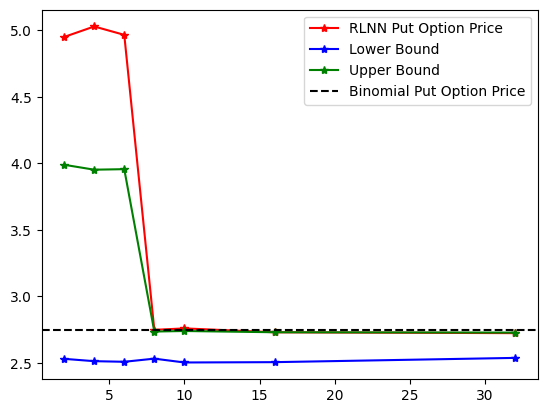

In [440]:
plt.plot(no_hidden_units, option_prices_nodes, label='RLNN Put Option Price', marker='*', color='r')
plt.plot(no_hidden_units, lower_Nodes, label='Lower Bound', marker='*', color='b')
plt.plot(no_hidden_units, upper_Nodes, label='Upper Bound', marker='*', color='g')
plt.axhline(y = binomial_price, label='Binomial Put Option Price', color='black', linestyle='--')
plt.legend()

In [ ]:
result2 = pd.DataFrame({'Hidden Units': no_hidden_units, 'Option Price': option_prices_nodes, 
                       'Lower Bound': lower_Nodes, 'Upper Bound': upper_Nodes, 'Option Time': times_option, 
                       'Lower Bound Time': times_lower, 'Upper Bound Time': times_upper})
result2.to_csv('Results50000_10000.csv', index=False)

In [301]:
import pandas as pd

In [302]:
result = pd.DataFrame({'Hidden Units': no_hidden_units, 'Option Price': option_prices_nodes, 
                       'Lower Bound': lower_Nodes, 'Upper Bound': upper_Nodes, 'Option Time': times_option, 
                       'Lower Bound Time': times_lower, 'Upper Bound Time': times_upper})
result.to_csv('Results2.csv', index=False)


In [303]:
result

,Hidden Units,Option Price,Lower Bound,Upper Bound,Option Time,Lower Bound Time,Upper Bound Time
0,4,2.772854,2.654385,2.766107,25.693694,13.741147,17.877704
1,8,2.761110,2.691059,2.757963,32.337805,24.703473,29.653594
2,16,2.756640,2.658749,2.758870,34.629444,42.353753,48.312969
3,32,2.754939,2.688834,2.755040,42.688968,74.112066,93.381687
4,64,2.753911,2.677748,2.752958,76.881100,179.530037,199.600654
5,128,2.751686,2.681418,2.752768,119.982530,303.548915,353.604264
